# A Basic Model

Initial scheme is just to predict basin-wide cyclone occurrence rate based on recent SSTs. How on earth will I begin??
Most basic way is:
- $y_i$: number of cyclones in season $i$. Assume $y_i ~ \text{Poisson}(\lambda_i)$,
where $\ln(\lambda_i) = \beta_0 + \mathbf{\beta}\mathbf{x}_i$
- $\mathbf{x}_i$: vector of predictors, including:
  - $t$: season number.
  - $x_i$: Average tropical SST for that season.
- $\beta_{SST}$: weight for average tropical SST.

The order of proceedings (from most simple/least useful to most useful):
1. seasonal SST vs seasonal cyclone numbers (just to get a general trend)
2. monthly SST average vs severe cyclone numbers (POISSON)
3. monthly SST average vs proportion of cyclones that are severe (LOGISTIC)

#### identity vs log link????


## 1. Absolute Seasonal Counts of Severe TCs
Actaully quite a useful exercise as we see the difference between the South Indian and South Pacific basins.

In [2]:
# get cyclone dataset
from utils.cyclone_utils import get_cyclone_data, time_to_season
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

severe_cyclone_df = get_cyclone_data(basin=None, min_cat=3,  one_per_id=True)
severe_cyclone_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982
480,21,1982-03-31 18:00:00,-3.2,159.2,SP,20,3,95,1981-1982
552,23,1982-04-23 06:00:00,-6.2,85.4,SI,20,3,100,1981-1982
931,36,1983-02-11 12:00:00,-10.6,157.7,SP,20,3,100,1982-1983
967,37,1983-02-20 12:00:00,-12.8,217.3,SP,25,3,100,1982-1983
...,...,...,...,...,...,...,...,...,...
30234,995,2019-03-14 18:00:00,-8.1,151.0,SP,25,3,110,2018-2019
30270,996,2019-03-18 06:00:00,-13.4,123.3,SI,20,4,130,2018-2019
30312,997,2019-03-21 18:00:00,-14.1,62.0,SI,25,3,120,2018-2019
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019


In [3]:
# get it into the format for our training -- season num (i) and y_i
FIRST_SZN = 1981
# only have half of the first season (first season = 1982 aug - 1983)
severe_cyclone_df['season_num'] = severe_cyclone_df['season'].apply(lambda x: int(x.split("-")[0]) - FIRST_SZN).astype('category')
severe_cyclone_df = severe_cyclone_df.loc[severe_cyclone_df.loc[:,'season_num'] != 0]

sp_severe_cyclone_df = severe_cyclone_df.loc[severe_cyclone_df.loc[:, 'basin'] == 'SP']

sp_cyclone_counts_df = sp_severe_cyclone_df.groupby('season_num').size().to_frame('cyclone_count').reset_index()
sp_cyclone_counts_df.set_index('season_num')

si_severe_cyclone_df = severe_cyclone_df.loc[severe_cyclone_df.loc[:, 'basin'] == 'SI']

si_cyclone_counts_df = si_severe_cyclone_df.groupby('season_num').size().to_frame('cyclone_count').reset_index()
si_cyclone_counts_df.set_index('season_num')


,cyclone_count
season_num,
0,0
1,0
2,4
3,2
4,6
5,0
6,3
7,7
8,5


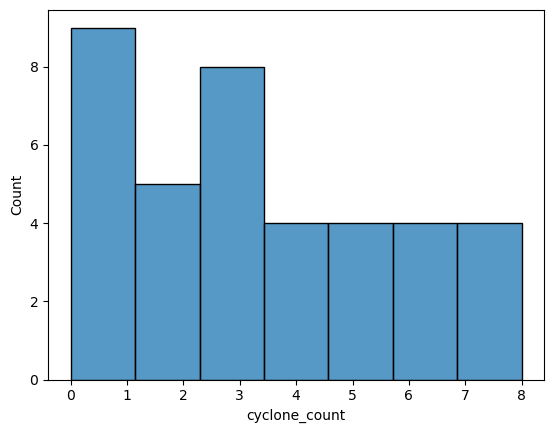

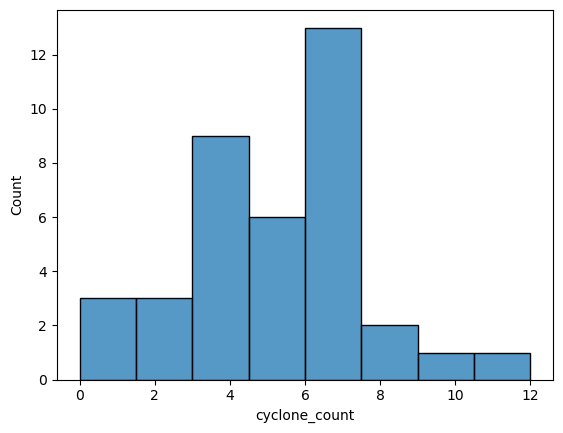

In [4]:
# histogram to sanity check poisson assumption
sns.histplot(data=sp_cyclone_counts_df, x='cyclone_count')
plt.show()
# histogram to sanity check poisson assumption
sns.histplot(data=si_cyclone_counts_df, x='cyclone_count')
plt.show()


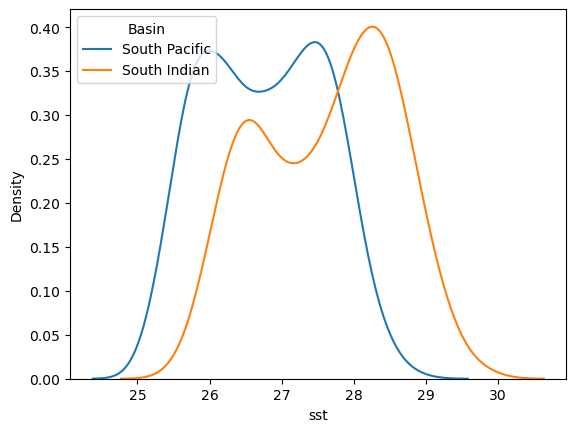

In [42]:
import xarray as xr
from netCDF4 import Dataset
# get cyclone dataset
from utils.globals import SP_MAX, SP_MIN, SI_MAX, SI_MIN

# get average topical sst for each season

monthly_avg_ssts = xr.open_dataset('../SST_data/Historical/sst.mon.mean.nc', engine='netcdf4')

sp_avg_ssts = monthly_avg_ssts.sel(lon=slice(SP_MIN, SP_MAX))
si_avg_ssts = monthly_avg_ssts.sel(lon=slice(SI_MIN, SI_MAX))

sp_tropical_avg = sp_avg_ssts.sel(lat=slice(-20,0)).mean(dim=['lon', 'lat'])

sns.kdeplot(sp_tropical_avg['sst'].to_series(), legend='SP')

si_tropical_avg = si_avg_ssts.sel(lat=slice(-20,0)).mean(dim=['lon', 'lat'])
sns.kdeplot(si_tropical_avg['sst'].to_series(), legend='SI')
plt.legend(title='Basin', loc='upper left', labels=['South Pacific', 'South Indian'])

# get rolling average over the cyclone season
sp_tropical_avg['rolling'] = sp_tropical_avg['sst'].rolling(time=12).mean().dropna(dim='time')
si_tropical_avg['rolling'] = si_tropical_avg['sst'].rolling(time=12).mean().dropna(dim='time')

sp_season_avg = sp_tropical_avg.sel(time=(sp_tropical_avg.time.dt.month == 7))
si_season_avg = si_tropical_avg.sel(time=(si_tropical_avg.time.dt.month == 7))

sp_relevant_seasons = sp_season_avg.sel(time=sp_season_avg.time.dt.year <= 2019)
si_relevant_seasons = si_season_avg.sel(time=si_season_avg.time.dt.year <= 2019)

sp_season_avg_df = sp_relevant_seasons['rolling'].dropna(dim='time').to_dataframe().reset_index()
si_season_avg_df = si_relevant_seasons['rolling'].dropna(dim='time').to_dataframe().reset_index()

sp_season_avg_df['season_num'] = sp_season_avg_df['time'].apply(lambda x: int(time_to_season(x).split("-")[0]) - FIRST_SZN).astype('category')
si_season_avg_df['season_num'] = si_season_avg_df['time'].apply(lambda x: int(time_to_season(x).split("-")[0]) - FIRST_SZN).astype('category')

sp_season_avg_df = sp_season_avg_df.loc[sp_season_avg_df.loc[:,'season_num'] != 0]
si_season_avg_df = si_season_avg_df.loc[si_season_avg_df.loc[:,'season_num'] != 0]


In [6]:
import pandas as pd
# Now have to merge the data into a common DF
sp_full_df = sp_season_avg_df.merge(sp_cyclone_counts_df,on='season_num',how='left')
sp_full_df['cyclone_count'] = sp_full_df['cyclone_count'].fillna(0)
sp_full_df



,time,rolling,season_num,cyclone_count
0,1983-07-01,27.169342,2,1.0
1,1984-07-01,26.654284,3,5.0
2,1985-07-01,26.322546,4,1.0
3,1986-07-01,26.393923,5,2.0
4,1987-07-01,26.803324,6,2.0
5,1988-07-01,26.763094,7,6.0
6,1989-07-01,26.167429,8,1.0
7,1990-07-01,26.467293,9,3.0
8,1991-07-01,26.624283,10,7.0
9,1992-07-01,26.837290,11,6.0


In [7]:

si_full_df = si_season_avg_df.merge(si_cyclone_counts_df,on='season_num',how='left')
si_full_df['cyclone_count'] = si_full_df['cyclone_count'].fillna(0)
si_full_df


,time,rolling,season_num,cyclone_count
0,1983-07-01,27.648119,2,4.0
1,1984-07-01,27.271263,3,2.0
2,1985-07-01,27.216026,4,6.0
3,1986-07-01,27.110647,5,0.0
4,1987-07-01,27.399549,6,3.0
5,1988-07-01,27.557772,7,7.0
6,1989-07-01,27.368439,8,5.0
7,1990-07-01,27.405092,9,4.0
8,1991-07-01,27.457670,10,6.0
9,1992-07-01,27.493959,11,4.0


In [8]:
# Step one: fully deterministic ML model from sklearn
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# n_samples = df_train.shape[0]
sp_full_df['const'] = 1
sp_X = sp_full_df.loc[:,['const', 'rolling']]
sp_y = sp_full_df.loc[:,'cyclone_count']

si_full_df['const'] = 1
si_X = si_full_df.loc[:,['const', 'rolling']]
si_y = si_full_df.loc[:,'cyclone_count']

# TODO: identity link?
sp_poisson_glm = PoissonRegressor(alpha=1e-12, solver="newton-cholesky")
sp_poisson_glm.fit(sp_X,sp_y)
print(sp_poisson_glm.coef_)

from joblib import dump
dump(sp_poisson_glm, 'saved_models/sp_seasonal_poisson.joblib') 

si_poisson_glm = PoissonRegressor(alpha=1e-12, solver="newton-cholesky")
si_poisson_glm.fit(si_X,si_y)
print(sp_poisson_glm.coef_)

dump(si_poisson_glm, 'saved_models/si_seasonal_poisson.joblib') 

[-4.16201346e-05  4.25424850e-01]
[-4.16201346e-05  4.25424850e-01]


['saved_models/si_seasonal_poisson.joblib']

In [9]:
import math
import numpy as np

vec_sqrt = np.vectorize(math.sqrt)

# coef are not too big and the sst one is negative??
sp_y_pred = sp_poisson_glm.predict(sp_X)
sp_with_pred_df = sp_full_df.assign(pred=sp_y_pred)

# TODO: RQR FOR THE TING
sp_with_pred_df['residual'] = sp_y_pred - sp_y
sp_with_pred_df['pearson'] = sp_with_pred_df['residual']/vec_sqrt(sp_y_pred)

si_y_pred = si_poisson_glm.predict(si_X)
si_with_pred_df = si_full_df.assign(pred=si_y_pred)
si_with_pred_df['residual'] = si_y_pred - si_y
si_with_pred_df['pearson']= si_with_pred_df['residual']/vec_sqrt(si_y_pred)

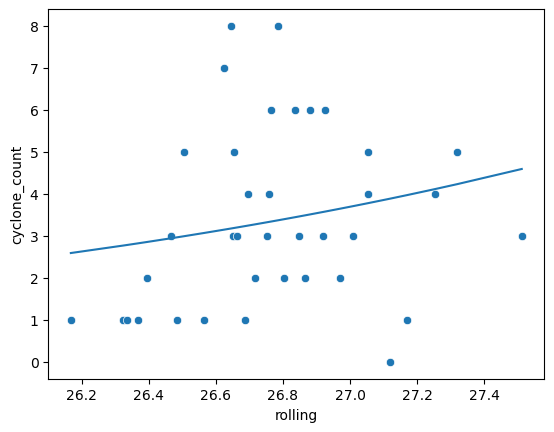

In [10]:
ax = sns.scatterplot(data=sp_with_pred_df, x='rolling', y='cyclone_count')
sns.lineplot(data=sp_with_pred_df, x='rolling', y='pred')
plt.show()
#sns.lineplot(data= pd.melt(with_pred_df.loc[:,['cyclone_count', 'pred', 'rolling']], 'rolling'), x='rolling', y='value', hue='variable')

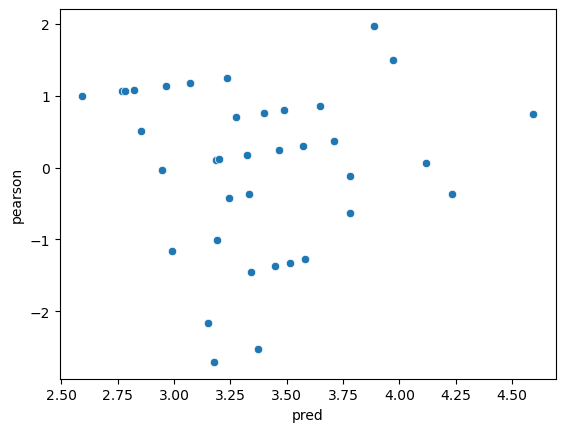

In [11]:
#residuals
ax = sns.scatterplot(data=sp_with_pred_df, x='pred', y='pearson')
plt.show()

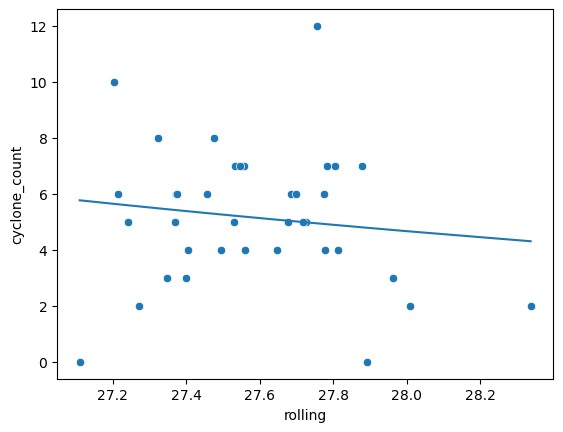

In [12]:
# check SP residuals
ax = sns.scatterplot(data=si_with_pred_df, x='rolling', y='cyclone_count')
sns.lineplot(data=si_with_pred_df, x='rolling', y='pred')
plt.show()

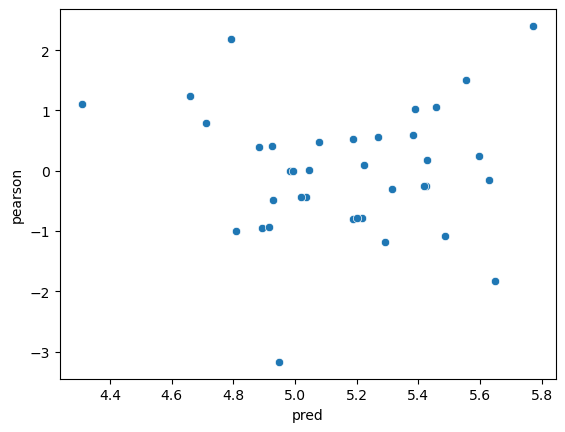

In [13]:
ax = sns.scatterplot(data=si_with_pred_df, x='pred', y='pearson') # SI SEEMS TO BE MORE NICELY BEHAVED IN TERMS OF EXPECTED POISSON RESIDUALS??
plt.show()

## 2. Month by Month
- monthly SST average vs proportion of cyclones becoming severe??
- November to april are the only months we should consider to eliminate noisy data


### rSST: local SST - global tropical mean (at that point in time)  

In [14]:
# get cyclone dataset
from utils.cyclone_utils import get_cyclone_data, time_to_season
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

## TODO: use monthly anomaly...
cyclone_df = get_cyclone_data(basin=None, min_cat=0, one_per_id=True)

cyclone_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season
0,1,1981-07-25 12:00:00,-11.8,86.7,SI,20,1,30,1981-1982
13,2,1981-10-21 06:00:00,-8.0,84.6,SI,40,2,85,1981-1982
38,3,1981-11-03 18:00:00,-8.6,92.9,SI,55,2,80,1981-1982
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982
...,...,...,...,...,...,...,...,...,...
30412,998,2019-04-03 06:00:00,-8.2,132.3,SP,20,1,60,2018-2019
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019
30456,1000,2019-04-21 18:00:00,-9.7,52.7,SI,20,4,125,2018-2019
30512,1001,2019-05-06 12:00:00,-5.6,129.9,SI,20,1,55,2018-2019


In [15]:
from utils.cyclone_utils import get_datetime
import numpy as np
# FOR EACH CYCLONE, GET AVG TROPICAL SST FOR THAT MONTH 
def get_monthly_sst(row):

    row_time = get_datetime(row['Time'])

    if row['basin'] == 'SP':
        year_entry = sp_tropical_avg.sel(time = (sp_tropical_avg.time.dt.year == row_time.year))
        month_entry = year_entry.sel(time= (year_entry.time.dt.month == row_time.month))
    else:
        year_entry = si_tropical_avg.sel(time = (si_tropical_avg.time.dt.year == row_time.year))
        month_entry = year_entry.sel(time = year_entry.time.dt.month == row_time.month)
    
    ret = month_entry['sst'].values

    if len(ret) > 0:
        return ret[0]
    else:
        return np.nan

# FOR EACH CYCLONE, GET AVG TROPICAL SST FOR THAT MONTH 
def get_month_sst_anomaly(month_sst, month_num, basin_str):
    print(f'called with {month_sst}, {month_num}, {basin_str}')
    if basin_str == 'SP':
        sst_dat = sp_tropical_avg
    else:
        sst_dat = si_tropical_avg

    month_vals = sst_dat.sel(time = (sst_dat['time.month'] == month_num))
    month_mean = month_vals['sst'].mean().values
    return month_sst - month_mean



cyclone_df['month_sst'] = cyclone_df.apply(get_monthly_sst, axis=1)
cyclone_df['month_anomaly'] = cyclone_df.apply(lambda row: get_month_sst_anomaly(row['month_sst'], get_datetime(row['Time']).month, row['basin']), axis=1)
cyclone_df = cyclone_df.dropna()
cyclone_df['is_severe'] = cyclone_df['category'].apply(lambda x: 1 if x >= 3 else 0)

cyclone_df['mm/yyyy'] = cyclone_df['Time'].apply(lambda x: datetime.strftime(get_datetime(x), "%m/%Y"))
cyclone_df['year'] = cyclone_df['Time'].apply(lambda x: get_datetime(x).year)
cyclone_df

## TRY LAG????



called with nan, 7, SI
called with 26.961009979248047, 10, SI
called with 27.260469436645508, 11, SI
called with 27.678617477416992, 12, SI
called with 27.678617477416992, 12, SI
called with 27.839811325073242, 1, SI
called with 27.839811325073242, 1, SI
called with 27.839811325073242, 1, SI
called with 27.090007781982422, 1, SP
called with 27.839811325073242, 1, SI
called with 27.839811325073242, 1, SI
called with 27.090007781982422, 1, SP
called with 27.090007781982422, 1, SP
called with 27.839811325073242, 1, SI
called with 27.839811325073242, 1, SI
called with 27.968175888061523, 2, SI
called with 27.968175888061523, 2, SI
called with 27.968175888061523, 2, SI
called with 28.2616024017334, 3, SI
called with 28.2616024017334, 3, SI
called with 27.450841903686523, 3, SP
called with 27.60091209411621, 4, SP
called with 28.5194149017334, 4, SI
called with 27.3381290435791, 5, SP
called with 26.221054077148438, 7, SI
called with 26.42002296447754, 10, SP
called with 26.725341796875, 11,

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_53558/147565808.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyclone_df['is_severe'] = cyclone_df['category'].apply(lambda x: 1 if x >= 3 else 0)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_53558/147565808.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyclone_df['mm/yyyy'] = cyclone_df['Time'].apply(lambda x: datetime.strftime(get_datetime(x), "%m/%Y"))
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_53558/14

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,month_sst,month_anomaly,is_severe,mm/yyyy,year
13,2,1981-10-21 06:00:00,-8.0,84.6,SI,40,2,85,1981-1982,26.961010,0.046761,0,10/1981,1981
38,3,1981-11-03 18:00:00,-8.6,92.9,SI,55,2,80,1981-1982,27.260469,-0.331079,0,11/1981,1981
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982,27.839811,-0.407703,1,01/1982,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30412,998,2019-04-03 06:00:00,-8.2,132.3,SP,20,1,60,2018-2019,28.334015,0.516489,0,04/2019,2019
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019,29.235092,0.445663,1,04/2019,2019
30456,1000,2019-04-21 18:00:00,-9.7,52.7,SI,20,4,125,2018-2019,29.235092,0.445663,1,04/2019,2019
30512,1001,2019-05-06 12:00:00,-5.6,129.9,SI,20,1,55,2018-2019,28.586384,0.381371,0,05/2019,2019


In [16]:
## FILTER DATA ONLY BY THE 'CYCLONE MONTHS' November-April TO ELIMINATE NOISE
cyclone_df = cyclone_df.loc[(cyclone_df.loc[:,'mm/yyyy'] >= '12/') | (cyclone_df.loc[:,'mm/yyyy'] <= '04/')]
si_df = cyclone_df.loc[cyclone_df.loc[:,'basin'] == 'SI']
sp_df = cyclone_df.loc[cyclone_df.loc[:,'basin'] == 'SP']
cyclone_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,month_sst,month_anomaly,is_severe,mm/yyyy,year
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982,27.839811,-0.407703,1,01/1982,1982
124,7,1982-01-11 12:00:00,-7.9,93.5,SI,20,1,35,1981-1982,27.839811,-0.407703,0,01/1982,1982
139,8,1982-01-13 06:00:00,-13.0,114.1,SI,30,1,50,1981-1982,27.839811,-0.407703,0,01/1982,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30160,993,2019-03-05 00:00:00,-17.1,37.5,SI,25,3,115,2018-2019,29.116810,0.371338,1,03/2019,2019
30205,994,2019-03-11 06:00:00,-11.6,103.8,SI,20,3,105,2018-2019,29.116810,0.371338,1,03/2019,2019
30234,995,2019-03-14 18:00:00,-8.1,151.0,SP,25,3,110,2018-2019,28.333965,0.477648,1,03/2019,2019
30270,996,2019-03-18 06:00:00,-13.4,123.3,SI,20,4,130,2018-2019,29.116810,0.371338,1,03/2019,2019


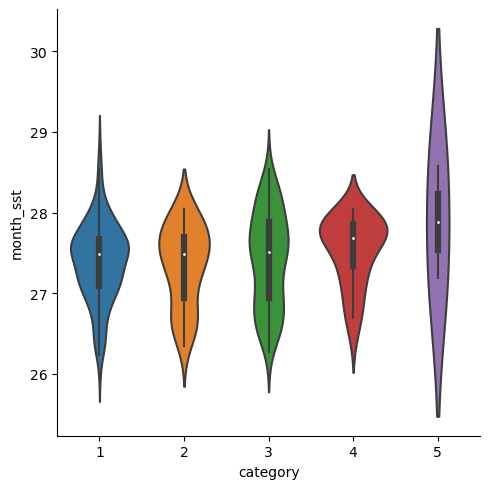

In [19]:
sns.catplot(x = 'category', y = 'month_sst', data = sp_df, kind='violin')

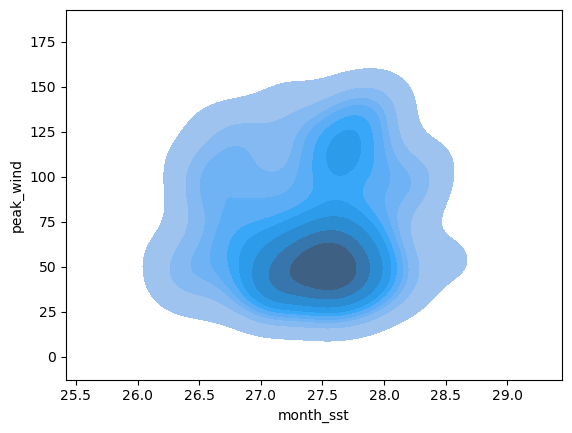

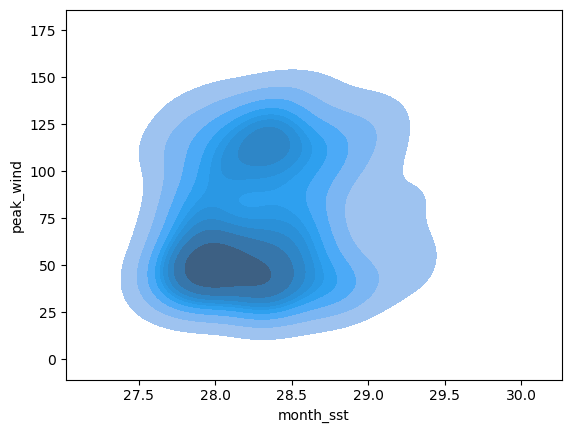

In [45]:
sns.kdeplot(data=sp_df, x='month_sst',y='peak_wind', fill=True)
plt.show()
sns.kdeplot(data=si_df, x='month_sst',y='peak_wind', fill=True)
plt.show()

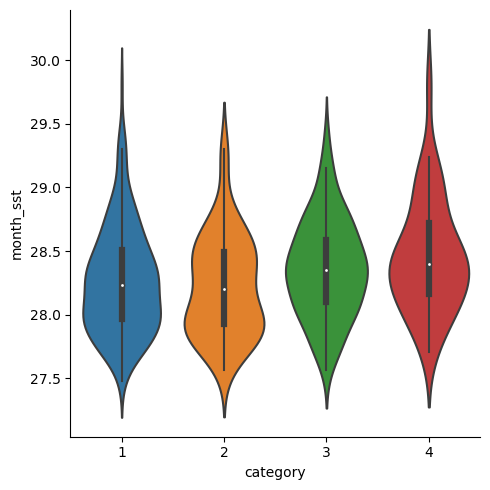

In [20]:
sns.catplot(x = 'category', y = 'month_sst', data = si_df, kind='violin')

### Logistic Regression: Effect of monthly average SST on the probability of a cyclone becoming severe
-> todo: potential weighting of higher categories??

South Pacific
      q           a             b        lb         ub
0  0.05   35.000003 -9.535956e-08 -7.180024   7.180024
1  0.15   40.000026 -9.226288e-07 -5.820131   5.820129
2  0.25   44.999996  1.757852e-07 -7.430528   7.430528
3  0.35 -157.733739  7.434496e+00 -1.336944  16.205935
4  0.45 -376.310176  1.552176e+01  4.638792  26.404737
5  0.55 -427.396434  1.774786e+01  3.205004  32.290710
6  0.65 -598.042672  2.426686e+01  9.118589  39.415129
7  0.75 -410.641821  1.818638e+01  6.867392  29.505373
8  0.85 -149.757107  9.377222e+00  0.107420  18.647025
9  0.95 -219.032147  1.229072e+01  5.093012  19.488437


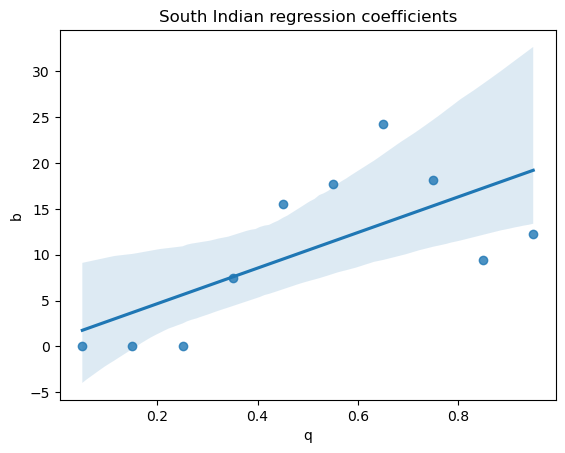

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


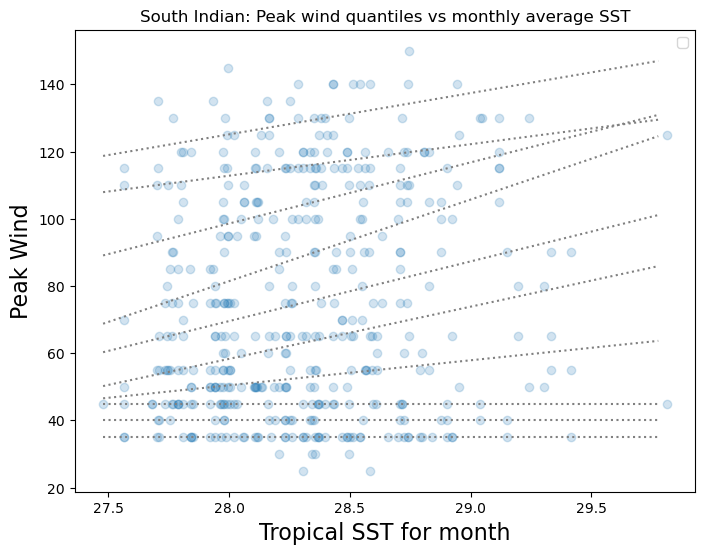

      q           a             b        lb         ub
0  0.05   34.999997  1.047435e-07 -5.839179   5.839180
1  0.15   39.999995  2.132879e-07 -5.765623   5.765623
2  0.25   44.999996  1.589318e-07 -6.371242   6.371242
3  0.35   54.999946  1.911906e-06 -7.504287   7.504291
4  0.45   60.000000 -2.558387e-08 -8.732398   8.732398
5  0.55  -78.257118  5.341648e+00 -5.987969  16.671264
6  0.65  -89.909890  6.389307e+00 -9.321304  22.099918
7  0.75  -29.174518  4.695396e+00 -9.228930  18.619721
8  0.85 -102.116155  7.942169e+00 -4.933578  20.817917
9  0.95 -215.764673  1.273486e+01  1.283140  24.186590


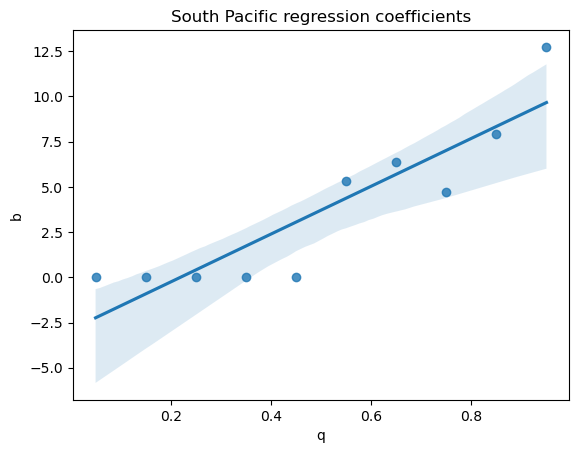

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


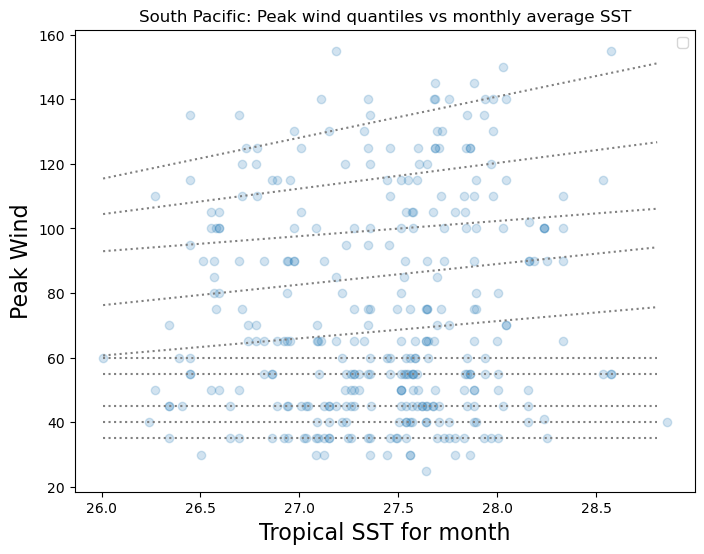

In [46]:
# TODO: Quantile regression -> top 10% of cyclones will look like??
import statsmodels.api as sm
import statsmodels.formula.api as smf

quantiles = np.arange(0.05, 0.96, 0.1)
def fit_model(quantile, model):
    res = model.fit(q=quantile)
    return [quantile, res.params["Intercept"], res.params["month_sst"]] + res.conf_int().loc[
        "month_sst"
    ].tolist()

get_y = lambda a, b: a + b * x

print("South Pacific")
for ent in [{'df': si_df, 'basin': 'South Indian'}, {'df': sp_df, 'basin': 'South Pacific'},]:
    df = ent['df']
    basin = ent['basin']
    model = smf.quantreg('peak_wind ~ month_sst', data=df)

    models = [fit_model(x, model) for x in quantiles]
    models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

    print(models)
    sns.regplot(data=models, x="q", y="b")
    plt.title(f'{basin} regression coefficients')
    plt.show()

    x = np.arange(df['month_sst'].min(), df['month_sst'].max(), 0.05)
    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(models.shape[0]):
        y = get_y(models.a[i], models.b[i])
        ax.plot(x, y, linestyle="dotted", color="grey")

    ax.scatter(df['month_sst'], df['peak_wind'], alpha=0.2)
    legend = ax.legend()
    plt.title(f'{basin}: Peak wind quantiles vs monthly average SST')
    ax.set_xlabel("Tropical SST for month", fontsize=16)
    ax.set_ylabel("Peak Wind", fontsize=16)
    plt.show()





In [ ]:
si_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,month_sst,month_anomaly,is_severe,mm/yyyy,year
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,27.678617,-0.388542,0,12/1981,1981
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982,27.839811,-0.407703,1,01/1982,1982
124,7,1982-01-11 12:00:00,-7.9,93.5,SI,20,1,35,1981-1982,27.839811,-0.407703,0,01/1982,1982
139,8,1982-01-13 06:00:00,-13.0,114.1,SI,30,1,50,1981-1982,27.839811,-0.407703,0,01/1982,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30141,992,2019-03-01 06:00:00,-9.9,76.5,SI,20,3,115,2018-2019,29.116810,0.371338,1,03/2019,2019
30160,993,2019-03-05 00:00:00,-17.1,37.5,SI,25,3,115,2018-2019,29.116810,0.371338,1,03/2019,2019
30205,994,2019-03-11 06:00:00,-11.6,103.8,SI,20,3,105,2018-2019,29.116810,0.371338,1,03/2019,2019
30270,996,2019-03-18 06:00:00,-13.4,123.3,SI,20,4,130,2018-2019,29.116810,0.371338,1,03/2019,2019


In [ ]:
sp_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,month_sst,month_anomaly,is_severe,mm/yyyy,year
157,9,1982-01-14 18:00:00,-11.7,132.3,SP,25,1,40,1981-1982,27.090008,-0.091301,0,01/1982,1982
239,12,1982-01-25 18:00:00,-18.0,154.1,SP,25,1,65,1981-1982,27.090008,-0.091301,0,01/1982,1982
240,13,1982-01-25 18:00:00,-16.9,173.2,SP,25,2,70,1981-1982,27.090008,-0.091301,0,01/1982,1982
480,21,1982-03-31 18:00:00,-3.2,159.2,SP,20,3,95,1981-1982,27.450842,-0.405476,1,03/1982,1982
708,29,1982-12-10 00:00:00,-9.0,200.0,SP,25,1,55,1982-1983,27.537970,0.741249,0,12/1982,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29839,984,2018-12-31 18:00:00,-10.2,161.8,SP,20,1,50,2018-2019,27.276909,0.480188,0,12/2018,2018
30014,989,2019-02-09 00:00:00,-16.8,183.1,SP,35,1,40,2018-2019,27.894545,0.336079,0,02/2019,2019
30035,990,2019-02-11 00:00:00,-16.5,161.7,SP,25,2,75,2018-2019,27.894545,0.336079,0,02/2019,2019
30112,991,2019-02-25 12:00:00,-12.8,183.9,SP,25,3,100,2018-2019,27.894545,0.336079,1,02/2019,2019


In [ ]:
# TRY A POISSON MODEL AT SMALL SCALES??


sp_df['severe_count'] = sp_df.groupby('mm/yyyy')['is_severe'].transform('sum')
sp_by_month = sp_df.loc[:,['mm/yyyy', 'year', 'month_sst', 'month_anomaly', 'severe_count']].drop_duplicates(subset='mm/yyyy') # A BIT HACKY

si_df['severe_count'] = si_df.groupby('mm/yyyy')['is_severe'].transform('sum')
si_by_month = si_df.loc[:,['mm/yyyy', 'year', 'month_sst', 'month_anomaly', 'severe_count']].drop_duplicates(subset='mm/yyyy') # A BIT HACKY
si_by_month

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_82047/565084805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_df['severe_count'] = sp_df.groupby('mm/yyyy')['is_severe'].transform('sum')
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_82047/565084805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_df['severe_count'] = si_df.groupby('mm/yyyy')['is_severe'].transform('sum')


,mm/yyyy,year,month_sst,month_anomaly,severe_count
71,12/1981,1981,27.678617,-0.388542,0
101,01/1982,1982,27.839811,-0.407703,1
357,02/1982,1982,27.968176,-0.468996,0
422,03/1982,1982,28.261602,-0.483870,0
733,12/1982,1982,28.302940,0.235781,0
...,...,...,...,...,...
29192,03/2018,2018,28.744162,-0.001310,2
29715,12/2018,2018,28.156340,0.089180,2
29911,01/2019,2019,28.594526,0.347012,0
29975,02/2019,2019,28.807339,0.370167,2


<Axes: xlabel='severe_count', ylabel='Count'>

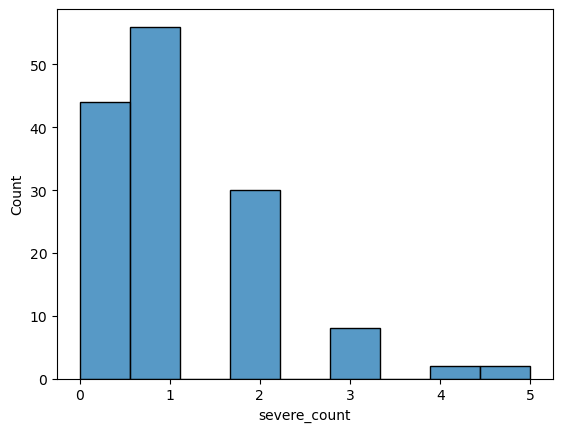

In [ ]:
sns.histplot(data=si_by_month,x='severe_count')

<Axes: xlabel='severe_count', ylabel='Count'>

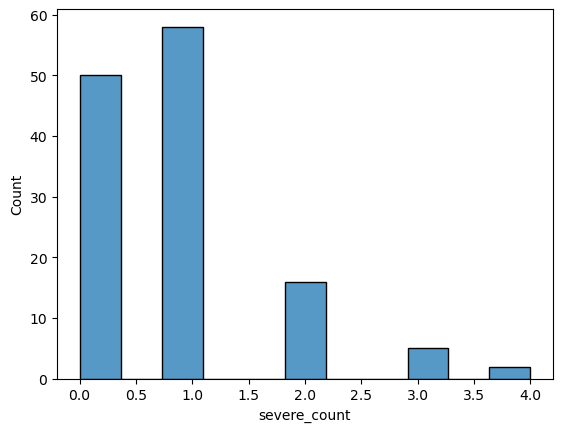

In [ ]:
sns.histplot(data=sp_by_month, x='severe_count')

In [ ]:
# Step one: fully deterministic ML model from sklearn
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# n_samples = df_train.shape[0]
sp_X = sp_by_month.loc[:,['month_sst', 'month_anomaly']]
sp_y = sp_by_month.loc[:,'severe_count']

si_X = si_by_month.loc[:,['month_sst', 'month_anomaly']]
si_y = si_by_month.loc[:,'severe_count']

sp_poisson_glm = PoissonRegressor(alpha=0.5, solver='lbfgs')
sp_poisson_glm.fit(sp_X,sp_y)
print(sp_poisson_glm.coef_)

from joblib import dump
dump(sp_poisson_glm, 'saved_models/sp_monthly_poisson.joblib') 

si_poisson_glm = PoissonRegressor(alpha=0.5, solver='lbfgs')
si_poisson_glm.fit(si_X,si_y)
print(si_poisson_glm.coef_)

dump(si_poisson_glm, 'saved_models/si_monthly_poisson.joblib') 

[0.07561629 0.00871874]
[ 0.08360581 -0.0246378 ]


['saved_models/si_monthly_poisson.joblib']

In [ ]:
import math
import numpy as np
import random
import scipy

#

vec_sqrt = np.vectorize(math.sqrt)

# coef are not too big and the sst one is negative??
sp_y_pred = sp_poisson_glm.predict(sp_X)
sp_with_pred_df = sp_by_month.assign(pred=sp_y_pred)

def poisson_pdf(y, lamb):
    return (math.exp(-lamb)*lamb**y)/math.factorial(y)

# try to do RQR residuals
# HOW TO GET PMF BASED ON OUR THING?? -> 
def get_rq_residual(y, y_pred):
    # RETURNS: DICT OF val: pmf
    i = 0
    cdf = 0
    while i < y:
        cdf += poisson_pdf(i, y_pred)
        i += 1

    cdf += random.uniform(0,1) * poisson_pdf(y,y_pred)
    return scipy.stats.norm.ppf(cdf)

rq_residuals_vectorized = np.vectorize(get_rq_residual)
sp_with_pred_df['rq_res'] = rq_residuals_vectorized(sp_y,sp_y_pred)


si_y_pred = si_poisson_glm.predict(si_X)
si_with_pred_df = si_by_month.assign(pred=si_y_pred)
si_with_pred_df['rq_res'] = rq_residuals_vectorized(si_y,si_y_pred)


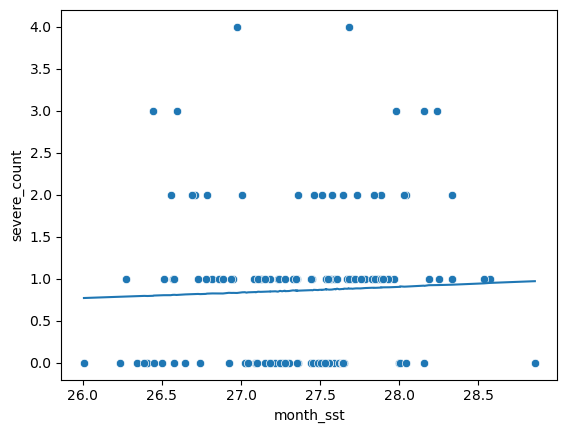

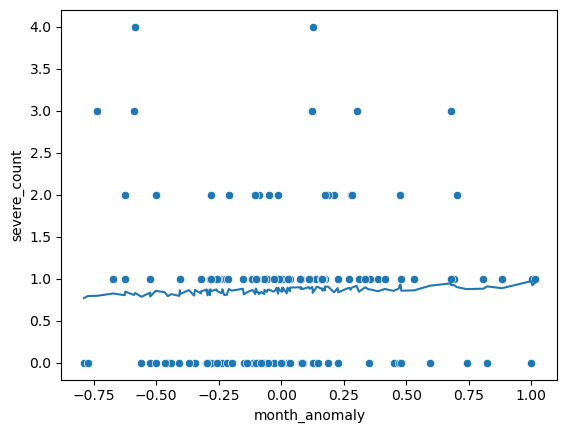

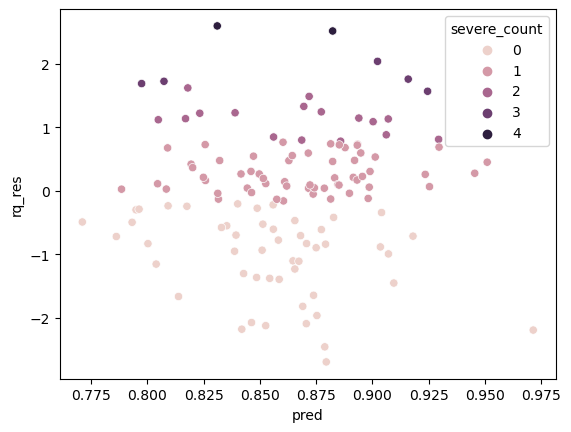

In [ ]:
ax = sns.scatterplot(data=sp_with_pred_df, x='month_sst', y='severe_count')
sns.lineplot(data=sp_with_pred_df, x='month_sst', y='pred')
plt.show()
# ax = sns.scatterplot(data=sp_with_pred_df, x='year', y='severe_count')
# sns.lineplot(data=sp_with_pred_df, x='year', y='pred')
# plt.show()
ax = sns.scatterplot(data=sp_with_pred_df, x='month_anomaly', y='severe_count')
sns.lineplot(data=sp_with_pred_df, x='month_anomaly', y='pred')
plt.show()

ax = sns.scatterplot(data=sp_with_pred_df, x='pred', y='rq_res', hue='severe_count')
plt.show()

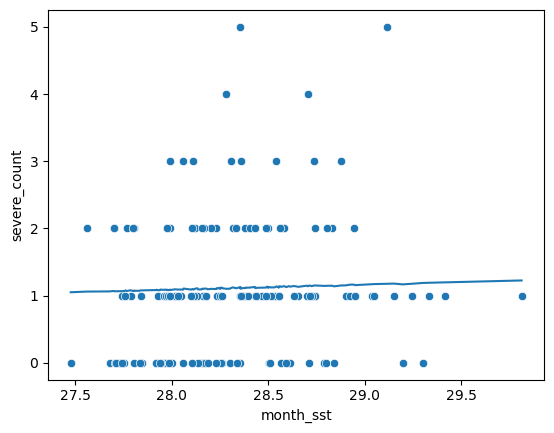

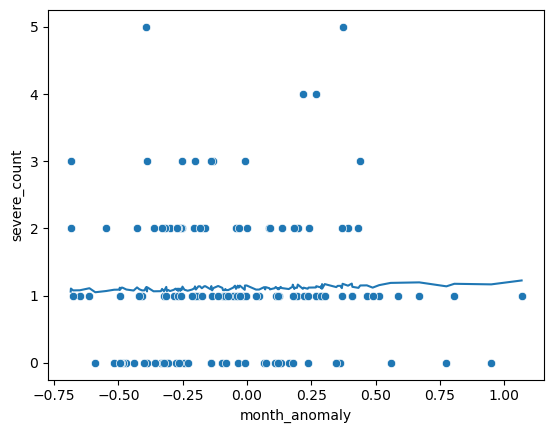

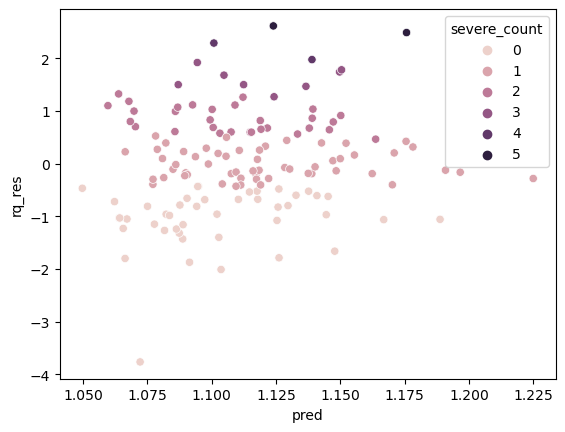

In [ ]:
ax = sns.scatterplot(data=si_with_pred_df, x='month_sst', y='severe_count')
sns.lineplot(data=si_with_pred_df, x='month_sst', y='pred')
plt.show()

# ax = sns.scatterplot(data=si_with_pred_df, x='year', y='severe_count')
# sns.lineplot(data=si_with_pred_df, x='year', y='pred')
# plt.show()

ax = sns.scatterplot(data=si_with_pred_df, x='month_anomaly', y='severe_count')
sns.lineplot(data=si_with_pred_df, x='month_anomaly', y='pred')
plt.show()

ax = sns.scatterplot(data=si_with_pred_df, x='pred', y='rq_res', hue='severe_count')
plt.show()

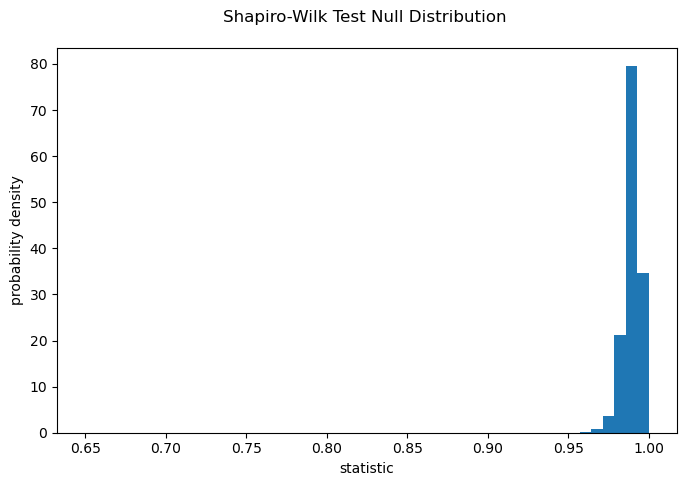

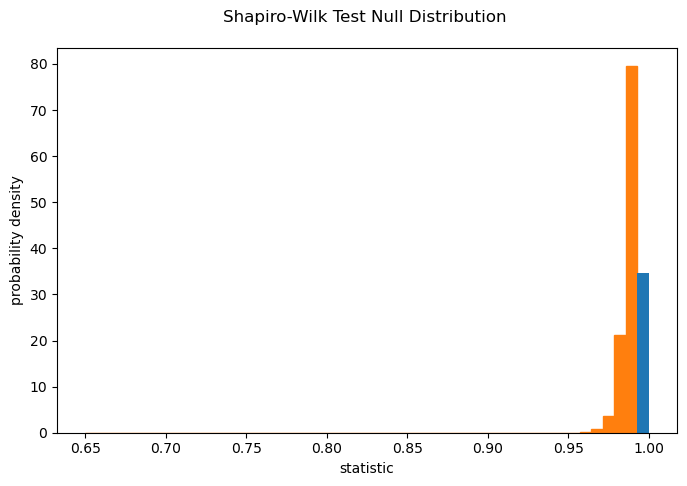

0.24242541193962097

In [ ]:
from scipy import stats

def statistic(x):
    # Get only the `shapiro` statistic; ignore its p-value
    return stats.shapiro(x).statistic

bins = np.linspace(0.65, 1, 50)
def plot(ax, ref):  # we'll re-use this
    ax.hist(ref.null_distribution, density=True, bins=bins)
    ax.set_title("Shapiro-Wilk Test Null Distribution \n")
    ax.set_xlabel("statistic")
    ax.set_ylabel("probability density")


res = stats.shapiro(sp_with_pred_df['rq_res'])
ref = stats.monte_carlo_test(sp_with_pred_df['rq_res'], stats.norm.rvs, statistic,
                             alternative='less')
fig, ax = plt.subplots(figsize=(8, 5))
plot(ax, ref)
plt.show()




fig, ax = plt.subplots(figsize=(8, 5))
plot(ax, ref)
annotation = (f'p-value={res.pvalue:.6f}\n(highlighted area)')
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
i_extreme = np.where(bins <= res.statistic)[0]
for i in i_extreme:
    ax.patches[i].set_color('C1')
plt.show()
res.pvalue



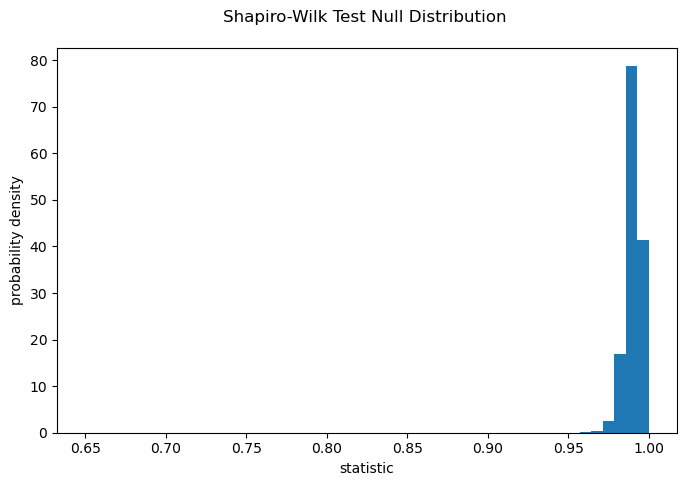

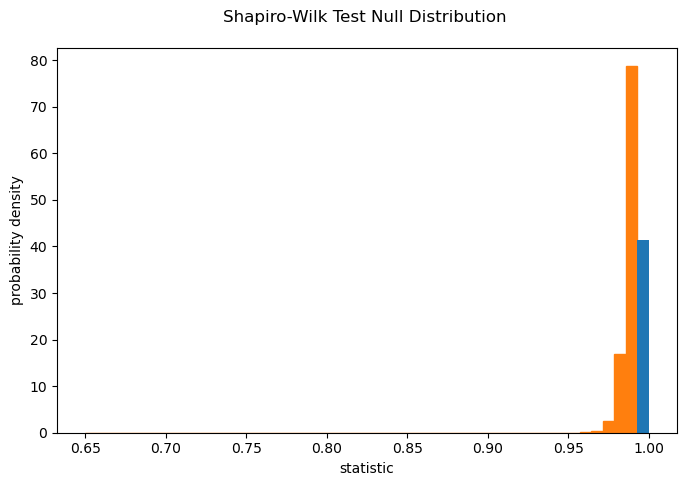

0.1687539666891098

In [ ]:
res = stats.shapiro(si_with_pred_df['rq_res'])
ref = stats.monte_carlo_test(si_with_pred_df['rq_res'], stats.norm.rvs, statistic,
                             alternative='less')
fig, ax = plt.subplots(figsize=(8, 5))
plot(ax, ref)
plt.show()




fig, ax = plt.subplots(figsize=(8, 5))
plot(ax, ref)
annotation = (f'p-value={res.pvalue:.6f}\n(highlighted area)')
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
i_extreme = np.where(bins <= res.statistic)[0]
for i in i_extreme:
    ax.patches[i].set_color('C1')
plt.show()
res.pvalue

### Last one: Logistic prediction of whether a cyclone becomes severe based on the monthly SST and monthly anomaly

In [ ]:
# Step one: fully deterministic ML model from sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns 

## TODO: multi-category prediction?

# n_samples = df_train.shape[0]
# NOTE: anomaly performs much better here.....
sp_X = sp_df.loc[:,['month_anomaly']]
sp_y = sp_df.loc[:,'is_severe']

si_X = si_df.loc[:,['month_anomaly']]
si_y = si_df.loc[:,'is_severe']

sp_logistic_glm = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
sp_logistic_glm.fit(sp_X,sp_y)
print(sp_logistic_glm.classes_)
print(sp_logistic_glm.coef_)
print(sklearn.metrics.roc_auc_score(sp_y, sp_logistic_glm.predict_proba(sp_X)[:, 1]))

from joblib import dump
dump(sp_logistic_glm, 'saved_models/sp_monthly_logistic.joblib') 

si_logistic_glm = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
si_logistic_glm.fit(si_X,si_y)
print(si_logistic_glm.classes_)
print(si_logistic_glm.coef_)
print(sklearn.metrics.roc_auc_score(si_y, si_logistic_glm.predict_proba(si_X)[:, 1]))
dump(si_logistic_glm, 'saved_models/si_monthly_logistic.joblib') 

[0 1]
[[0.18288501]]
0.5588432663674875
[0 1]
[[0.33465905]]
0.5629355710425259


['saved_models/si_monthly_logistic.joblib']

In [ ]:
sp_y_pred = sp_logistic_glm.predict_proba(sp_X)[:,1]
sp_with_pred_df = sp_df.assign(pred=sp_y_pred)

si_y_pred = si_logistic_glm.predict_proba(si_X)[:,1]
si_with_pred_df = si_df.assign(pred=si_y_pred)

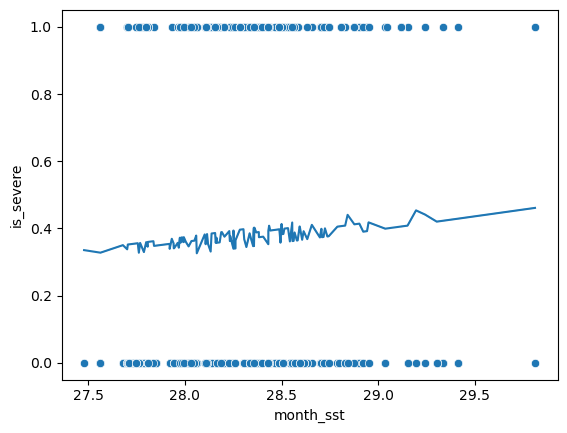

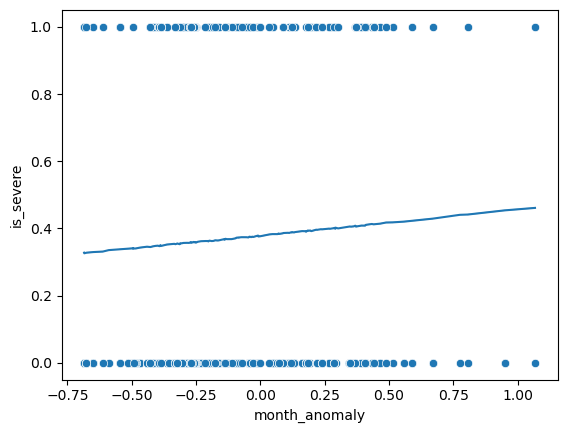

In [ ]:
ax = sns.scatterplot(data=si_with_pred_df, x='month_sst', y='is_severe')
sns.lineplot(data=si_with_pred_df, x='month_sst', y='pred')
plt.show()

# ax = sns.scatterplot(data=si_with_pred_df, x='year', y='severe_count')
# sns.lineplot(data=si_with_pred_df, x='year', y='pred')
# plt.show()

ax = sns.scatterplot(data=si_with_pred_df, x='month_anomaly', y='is_severe')
sns.lineplot(data=si_with_pred_df, x='month_anomaly', y='pred')
plt.show()


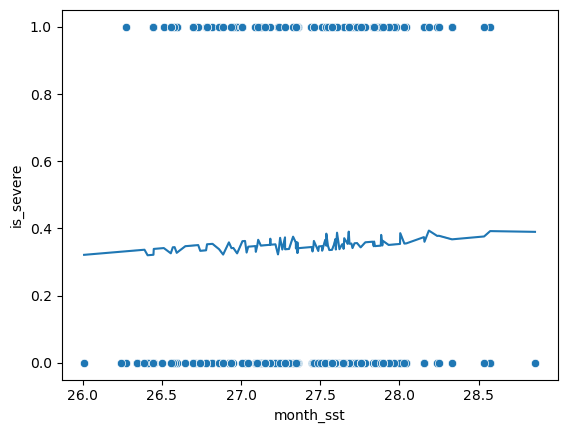

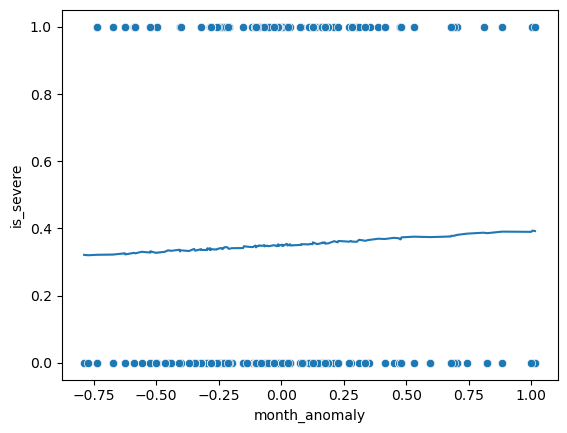

In [ ]:
ax = sns.scatterplot(data=sp_with_pred_df, x='month_sst', y='is_severe')
sns.lineplot(data=sp_with_pred_df, x='month_sst', y='pred')
plt.show()

# ax = sns.scatterplot(data=si_with_pred_df, x='year', y='severe_count')
# sns.lineplot(data=si_with_pred_df, x='year', y='pred')
# plt.show()

ax = sns.scatterplot(data=sp_with_pred_df, x='month_anomaly', y='is_severe')
sns.lineplot(data=sp_with_pred_df, x='month_anomaly', y='pred')
plt.show()

# Let's plug it into CMIP

In [ ]:
cmip_ssts = xr.open_dataset('../SST_data/CMIP/CMIP_ssp370_Omon_tos-mean.nc', engine='netcdf4')
cmip_ssts

<xarray.Dataset>
Dimensions:        (time: 1032, latitude: 192, longitude: 288)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T1...
  * latitude       (latitude) float64 -89.53 -88.59 -87.66 ... 87.66 88.59 89.53
  * longitude      (longitude) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    tos_mean_mean  (time, latitude, longitude) float32 ...
    tos_mean_std   (time, latitude, longitude) float32 ...
    tos_mean_min   (time, latitude, longitude) float32 ...
    tos_mean_max   (time, latitude, longitude) float32 ...
Attributes:
    experiment:            gap-filling scenario reaching 7.0 based on SSP3
    variable_id:           tos
    table_id:              Omon
    frequency:             mon
    activity_id:           ScenarioMIP AerChemMIP
    experiment_id:         ssp370
    source_id:             ['FGOALS-f3-L', 'NorESM2-LM', 'MRI-ESM2-0', 'EC-Ea...
    scenario_variables:    ['tas_mean', 'tos_mean', 'sos_mean', 'siconc_mean']
    scenario_experiments:  ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp5...

## NOTES/TODO
- residuals
- more granular temperature measurements/time intervals
- something a little bit more Bayesian
- Work in the GCM data and see what will happen
- brms/Bambi

### Issue: not much data especially when we look at more severe cyclones??
- Potentially backtrack to reanalysis data to boost the dataset?